<center><h1>Basic Playlist Continuation</h1></center>
<hr>

> RecSys 2018 과제인 Playlist Continuation 일련의 과정을 수행한다.

<h2>References</h2><br>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF", target="_blank">sklearn - Matrix Decomposition</a>

<div id="top"><h2>Table of Contents</h2></div>
<ol>
    <li><a href="#1">Task Overview</a></li>
    <li><a href="#2">Data Description</a></li>
    <li><a href="#3">Prepare Data</a></li>
    <ol>
        <li><a href="#3.1">Import Library</a></li>
        <li><a href="#3.2">Load Data</a></li>
        <li><a href="#3.3">Preprocess Data</a></li>
    </ol>
    <li><a href="#4">Exploratory Data Analysis</a></li>
    <ol>
        <li><a href="#4.1">Number of Track in Playlist</a></li>
    </ol>
    <li><a href="#5">Data Modeling</a></li>
    <ol>
        <li><a href="#5.1">Split Data</a></li>
        <li><a href="#5.2">Matrix Decomposition</a></li>
        <li><a href="#3.3">Preprocess Data</a></li>
    </ol>
</ol>
<hr>

<div id="1"><h1>1. Task Overview</h1></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

> RecSys 2018 과제인 Playlist Continuation은 Track이 일부 비어있는 Playlist가 주어졌을 때, 적절한 Track을 추천하는 과제이다. 논문에서는 K-NN, Neural Network와 같은 방법을 활용하여서 문제를 해결한다.

<div id="2"><h1>2. Data Description</h1></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

> Spotify에서 제공하는 Million Playlist Dataset(MPD)의 일부를 사용한다. JSON 형식에 파일에는 Playlist, Track에 대한 기본적인 metadata를 포함한다.

<div id="3"><h1>3. Prepare Data</h1></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

<div id="3.1"><h2>3.1. Import Library</h2></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

In [1]:
### Numerical Data
import numpy as np

### Loop Visualization
from tqdm import tqdm

### Visualization
import matplotlib.pyplot as plt

### Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF

### Json
import json

<div id="3.2"><h2>3.2. Load Data</h2></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

In [2]:
def load_data(filepath):
    json_str = ''
    with open(filepath, encoding='utf-8') as f:
        for line in tqdm(f.read()):
            json_str += line
    data = json.loads(json_str)
    
    return data

In [3]:
data = load_data('./data/mpd.slice.0-999.json')

100%|██████████| 34119368/34119368 [00:11<00:00, 3002564.70it/s]


<div id="3.3"><h2>3.3. Preprocess Data</h2></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

In [4]:
def extrack_playlist_track(data):
    playlist_track = dict()
    playlist = set()
    track = set()
    
    for p in tqdm(data['playlists']):
        playlist_name = '-'.join([p['name'], str(p['pid'])])
        playlist.add(playlist_name)
        playlist_track[playlist_name] = list()
        for t in p['tracks']:
            track_name = t['track_name']
            track.add(track_name)
            playlist_track[playlist_name].append(track_name)
    playlist = list(playlist)
    track = list(track)

    return playlist_track, playlist, track

In [5]:
playlist_track, playlist, track = extrack_playlist_track(data) 

100%|██████████| 1000/1000 [00:00<00:00, 30348.20it/s]


In [6]:
def get_dictionary(playlist, track):
    playlist2idx = {p: idx for idx, p in enumerate(playlist)}
    idx2playlist = {idx: p for idx, p in enumerate(playlist)}
    track2idx = {t: idx for idx, t in enumerate(track)}
    idx2track = {idx: t for idx, t in enumerate(track)}
    
    return playlist2idx, idx2playlist, track2idx, idx2track

In [7]:
playlist2idx, idx2playlist, track2idx, idx2track = get_dictionary(playlist, track)

In [8]:
print('Length of Playlist Track Pair: {}'.format(len(playlist_track)))

Length of Playlist Track Pair: 1000


In [9]:
print('Length of Playlist: {}'.format(len(playlist)))

Length of Playlist: 1000


In [10]:
print('Length of Track: {}'.format(len(track)))

Length of Track: 30049


In [11]:
N_PLAYLIST = len(playlist)
N_TRACK = len(track)

In [12]:
def convert_to_matrix(playlist_track, playlist2idx=playlist2idx, track2idx=track2idx, binary=True):
    p2t_matrix = np.zeros((N_PLAYLIST, N_TRACK))
    
    for playlist, tracks in playlist_track.items():
        p_id = playlist2idx[playlist]
        for track in tracks:
            t_id = track2idx[track]
            if binary:
                p2t_matrix[p_id][t_id] = 1
            else:
                p2t_matrix[p_id][t_id] += 1
    
    return p2t_matrix

In [13]:
p2t_matrix = convert_to_matrix(playlist_track)

<div id="4"><h1>4. Exploratory Data Analysis</h1></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

<div id="4.1"><h2>4.1. Number of Track in Playlist</h2></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

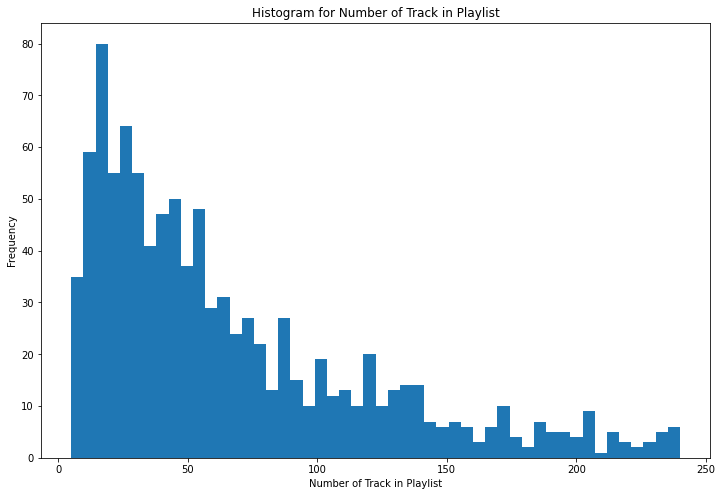

In [14]:
plt.figure(figsize=(12, 8))
plt.hist(p2t_matrix.sum(axis=1), bins=50)
plt.xlabel('Number of Track in Playlist')
plt.ylabel('Frequency')
plt.title('Histogram for Number of Track in Playlist')
plt.show()

<div id="5"><h1>5. Data Modeling</h1></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

<div id="5.1"><h2>5.1. Split Data</h2></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

**Data Description**
> **Whole Data**
> <br>
> p2t_matrix: playlist-to-track matrix origianl version<br>
> p2t_matrix_masked: playlist-to-track matrix masked version<br>

> **Training Data**
> <br>
> train_id: playlist id for train_data. index at train_data leads to original playlist id<br>
> train_data: partial p2t_matrix for training.<br>

> **Validation Data**
> <br>
> validation_id: playlist id for validation_data. index at validation_id leads to original playlist id<br>
> validation_data: partial p2t_matrix for validation. <br>
> validation_data_masked: partial p2t_matrix for validation with masked.<br>
> validation_track_length: original number of track of partial p2t_matrix for validation.<br>

> **Test Data**
> <br>
> test_id: playlist id for test_data. index at test_id leads to original playlist id<br>
> test_data: partial p2t_matrix for test. <br>
> test_data_masked: partial p2t_matrix for test with masked.<br>
> test_track_length: original number of track of partial p2t_matrix for test.<br>

In [15]:
def split_data(data):
    train_id, test_id, train_data, test_data = train_test_split(
        range(0, 1000), 
        data, 
        test_size=0.1, 
        random_state=2020
    )
    
    train_id, validation_id, train_data, validation_data = train_test_split(
        train_id,
        train_data,
        test_size=0.2, 
        random_state=2020
    )
    
    return train_id, validation_id, test_id, train_data, validation_data, test_data


In [16]:
train_id, validation_id, test_id, train_data, validation_data, test_data = split_data(p2t_matrix)

In [17]:
print('Train: {}, Validation: {}, Test: {}'.format(train_data.shape[0], validation_data.shape[0], test_data.shape[0]))

Train: 720, Validation: 180, Test: 100


In [18]:
def mask_data(playlist_id, playlist, p2t_matrix, rate=0.5):
    length = list()
    for pid, p in zip(playlist_id, playlist):
        tid = np.where(p == 1)[0]
        
        n_track = len(tid)
        length.append(n_track)
        masked_tid = tid[np.random.choice(n_track, int(n_track * rate))]
        
        p[masked_tid] = 0
        p2t_matrix[pid][masked_tid] = 0
        
    return length

In [19]:
p2t_matrix_masked = p2t_matrix.copy()

In [20]:
validation_data_masked = validation_data.copy()
validation_track_length = mask_data(validation_id, validation_data_masked, p2t_matrix_masked)

In [21]:
test_data_masked = test_data.copy()
test_track_length = mask_data(test_id, test_data_masked, p2t_matrix_masked)

In [22]:
np.where(validation_data[0] == 1)[0] == np.where(p2t_matrix[validation_id[0]] == 1)[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [23]:
np.where(validation_data_masked[0] == 1)[0] == np.where(p2t_matrix_masked[validation_id[0]] == 1)[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [24]:
validation_track_length == validation_data.sum(axis=1).astype(int)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [25]:
test_track_length == test_data.sum(axis=1).astype(int)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

<div id="5.2"><h2>5.2. Matrix Decomposition</h2></div>
<p style="text-align:right;"><a href="#top">🔝 top</a></p>

In [40]:
N_COMPONENTS = 300

In [41]:
def train_model(data):
    nmf = NMF(n_components=N_COMPONENTS, max_iter=100, random_state=2020, alpha=0.08, verbose=True)
    nmf.fit(data)
    return nmf

In [42]:
model = train_model(p2t_matrix_masked)

violation: 1.0
violation: 0.08426914169699048
violation: 0.04996255928479021
violation: 0.035433407728093315
violation: 0.026897412723445847
violation: 0.049114205229110815
violation: 0.03989732196865256
violation: 0.02727099746774174
violation: 0.020950835286240643
violation: 0.01670520444665249
violation: 0.013697293427482934
violation: 0.011467745447242493
violation: 0.009821810660649733
violation: 0.008839689346223175
violation: 0.007853526350285914
violation: 0.006936641185531231
violation: 0.006024311353940717
violation: 0.005393653223279284
violation: 0.004952385224568362
violation: 0.004596203309682206
violation: 0.004288697353387924
violation: 0.004028291554915588
violation: 0.003821697789586774
violation: 0.0036681569770139408
violation: 0.0035536665155918253
violation: 0.0034505270277482235
violation: 0.003355080097477563
violation: 0.003257361815530495
violation: 0.003132288610715801
violation: 0.0029815264022166367
violation: 0.00280868766921322
violation: 0.00263523388097

In [43]:
def predict(model, data):
    data = model.transform(data)
    data = np.matmul(data, model.components_)
    return data

In [44]:
prediction = predict(model, validation_data_masked)

violation: 1.0
violation: 0.5893918963638867
violation: 0.04767472370702755
violation: 0.013075794374159035
violation: 0.004161540006468447
violation: 0.0013054792316113558
violation: 0.0004809176179087992
violation: 0.00020085757552198885
violation: 7.421522506253951e-05
Converged at iteration 9


In [45]:
def calculate_rprec(pred, real):
    correct = sum([1 if p in real else 0 for p in pred])
    return correct / len(pred)

In [48]:
def evaluate(pred, real, real_length):
    score = 0.0
    
    assert pred.shape[0] == real.shape[0]
    size = pred.shape[0]
    
    for idx in range(size):
        length = real_length[idx]
        recommendation = np.argsort(pred[idx])[::-1][:length]
        answer = np.where(real[idx] == 1)[0]
        rprec = calculate_rprec(recommendation, answer)
        score += rprec
    
    return score / size

In [49]:
score = evaluate(prediction, validation_data, validation_track_length)
print('R Precision Score: {}'.format(score))

53
0.2830188679245283
66
0.2727272727272727
10
0.0
26
0.23076923076923078
5
0.4
73
0.1917808219178082
26
0.15384615384615385
15
0.2
183
0.5956284153005464
131
0.5267175572519084
78
0.23076923076923078
66
0.19696969696969696
88
0.17045454545454544
23
0.13043478260869565
8
0.0
19
0.10526315789473684
57
0.22807017543859648
28
0.07142857142857142
42
0.023809523809523808
97
0.23711340206185566
21
0.14285714285714285
16
0.375
26
0.23076923076923078
23
0.08695652173913043
20
0.2
186
0.6344086021505376
17
0.17647058823529413
187
0.6310160427807486
19
0.2631578947368421
101
0.12871287128712872
110
0.13636363636363635
47
0.10638297872340426
20
0.2
46
0.17391304347826086
88
0.2727272727272727
27
0.1111111111111111
70
0.45714285714285713
18
0.3333333333333333
32
0.15625
124
0.6209677419354839
14
0.07142857142857142
75
0.05333333333333334
18
0.4444444444444444
19
0.3157894736842105
65
0.07692307692307693
30
0.13333333333333333
21
0.3333333333333333
39
0.1282051282051282
28
0.03571428571428571
139
0